Notes:
 * revised and tuned configuration

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1'
data_files = '/mnt/tess/astronet/tfrecords-27-val/*'
tces_file = '/mnt/tess/astronet/tces-v8-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/1/AstroCNNModel_revised_tuned_20211004_153131',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/2/AstroCNNModel_revised_tuned_20211004_153435',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/3/AstroCNNModel_revised_tuned_20211004_153755',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/4/AstroCNNModel_revised_tuned_20211004_154057',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/5/AstroCNNModel_revised_tuned_20211004_154358',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/6/AstroCNNModel_revised_tuned_20211004_154813',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/7/AstroCNNModel_revised_tuned_20211004_155116',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/8/AstroCNNModel_revised_tuned_20211004_155424',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/9/AstroCNNModel_revised_tuned_20211004_155727',
 '/mnt/tess/astronet/checkpoints/revised_tuned_27_run_1/10/Astro

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2270 records
Running model 2
2270 records
Running model 3
2270 records
Running model 4
2270 records
Running model 5
2270 records
Running model 6
2270 records
Running model 7
2270 records
Running model 8
2270 records
Running model 9
2270 records
Running model 10
2270 records


In [3]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.3

In [18]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [5]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [8]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [9]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9747899159663865
Precision: 0.6987951807228916


In [10]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

104485403
334227600
369264198
118412801
141753278
349412074


In [11]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

109851914
283330382
14209654
16740282
188258751
188655930
199376584
202685576
267924099
136651206
277848886
417208086
252588526
431338538
192591652
198555242
279064110
332870317
347492958
468608862
94280922
127846210
164528404
18178958
193799560
198183483
233197293
237278147
27896467
405687343
111269865
122577745
261814771
269291226
408945155
646535555
142751024
147607082
257048642
56861756
91987762
137810570
138847344
165373714
18907019
154271808
159636125
198147416
219824182
230197530
284266496
298647682
113496703
118398402
167039826
167809450
177309966
201601338
21601170
220374696
25133152
261205462
261419829
273654759
276738707
276965481
278632192
278724765
281578420
293527927
30275847
30407196
30722286
311103813
317382479
318518150
31868634
319865847
322284262
325279192
326693475
340178535
341119264
350137597
363404187
373919592
379191982
384341508
394288878
404851508
404851966
404934011
40602499
406971913
407615704
410087746
419611478
466270949
87060979
90482156


In [12]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 404220255)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
404220255,0.276559,0.052964,0.070522,0.000063,0.641846
404220255,0.764950,0.033478,0.063883,0.001689,0.163159
404220255,0.492020,0.036388,0.044731,0.000581,0.512987
404220255,0.655110,0.078525,0.106846,0.000520,0.196658
404220255,0.517818,0.137284,0.152360,0.001717,0.253745
404220255,0.473780,0.065924,0.103289,0.000747,0.339534
404220255,0.345735,0.093233,0.137834,0.002167,0.452641
404220255,0.134310,0.063326,0.135073,0.000147,0.635137
404220255,0.461236,0.078566,0.146576,0.000480,0.292257


In [13]:
pl[pl.index == 421845505]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [14]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [15]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9721361742061021, max R: 1.0, max P: 1.0
100% recall at: 31%, threshold: 0.012486290931756239


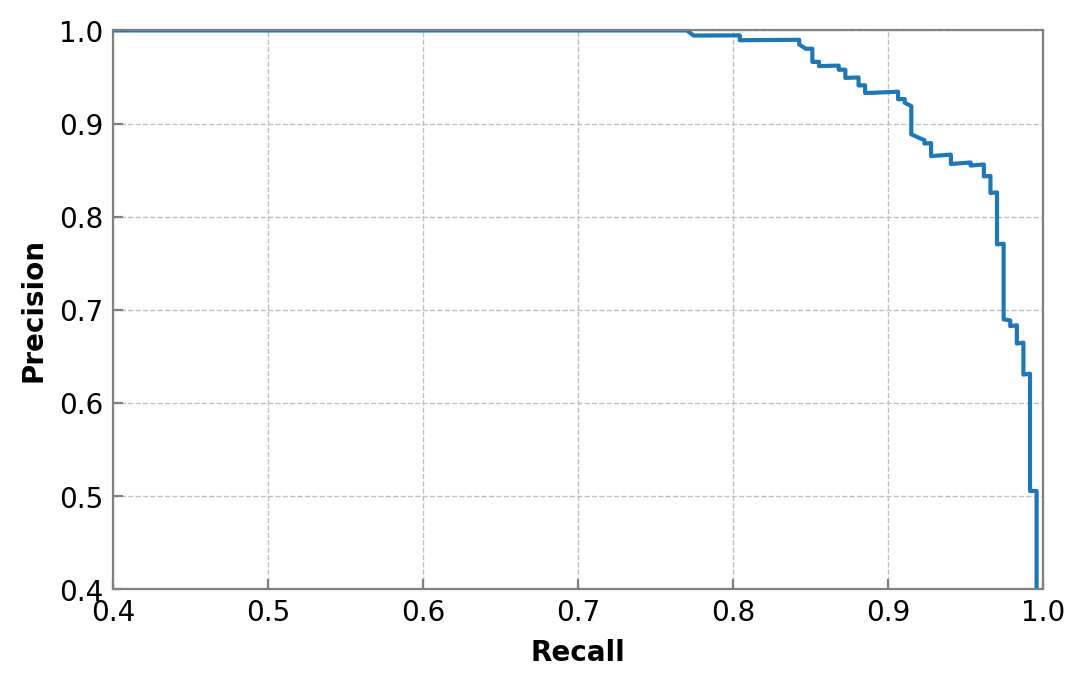

In [16]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.4, 1.0))
plt.ylim((0.4, 1.0))

_ = plt.plot(rs, ps)